In [1]:
import numpy as np
from signal_io.base import Signal

# Fake ECG data: 2 channels, 5000 samples, sampled at 500 Hz
data = np.random.randn(2, 5000)

ecg_signal = Signal(
    data=data,
    sampling_rate=500,
    metadata={"patient_id": "123", "lead": "II"}
)

ecg_signal.summary()
print(f"Duration: {ecg_signal.duration:.2f} seconds")  # → 10.00 seconds

# Make a modified copy without affecting original
filtered = ecg_signal.copy()
filtered.data = np.abs(filtered.data)  # e.g., rectification

Signal Summary
----------------------------------------
Sampling Rate : 500 Hz
Channels      : 2
Samples       : 5,000
Duration      : 10.000 seconds
Metadata      : {'patient_id': '123', 'lead': 'II'}
Duration: 10.00 seconds


In [3]:
from signal_io.audio import load_audio, ensure_mono, resample

# Load a stereo music file at native rate
music = load_audio("C:\\Users\\dipti\\Downloads\\wake-up-call-111748.mp3", mono=False)

print(music.channels)        
print(music.sr)              

# Later decide you need 16kHz mono for a speech model
mono_16k = ensure_mono(music)
final = resample(mono_16k, target_sr=16000)

final.summary()
# You'll see conversion history in metadata

2
48000
Signal Summary
----------------------------------------
Sampling Rate : 16000 Hz
Channels      : 1
Samples       : 1,136,640
Duration      : 71.040 seconds
Metadata      : {'source_file': 'C:\\Users\\dipti\\Downloads\\wake-up-call-111748.mp3', 'domain': 'audio', 'original_sr': 48000, 'conversion': ['to_mono_by_averaging', 'resampled_48000_to_16000Hz']}


Original signal:
Signal Summary
----------------------------------------
Sampling Rate : 500 Hz
Signal Type   : ecg
Channels      : 1
Samples       : 5,000
Duration      : 10.000 seconds
Metadata      : {'patient_id': '001', 'domain': 'ecg', 'description': 'synthetic'}


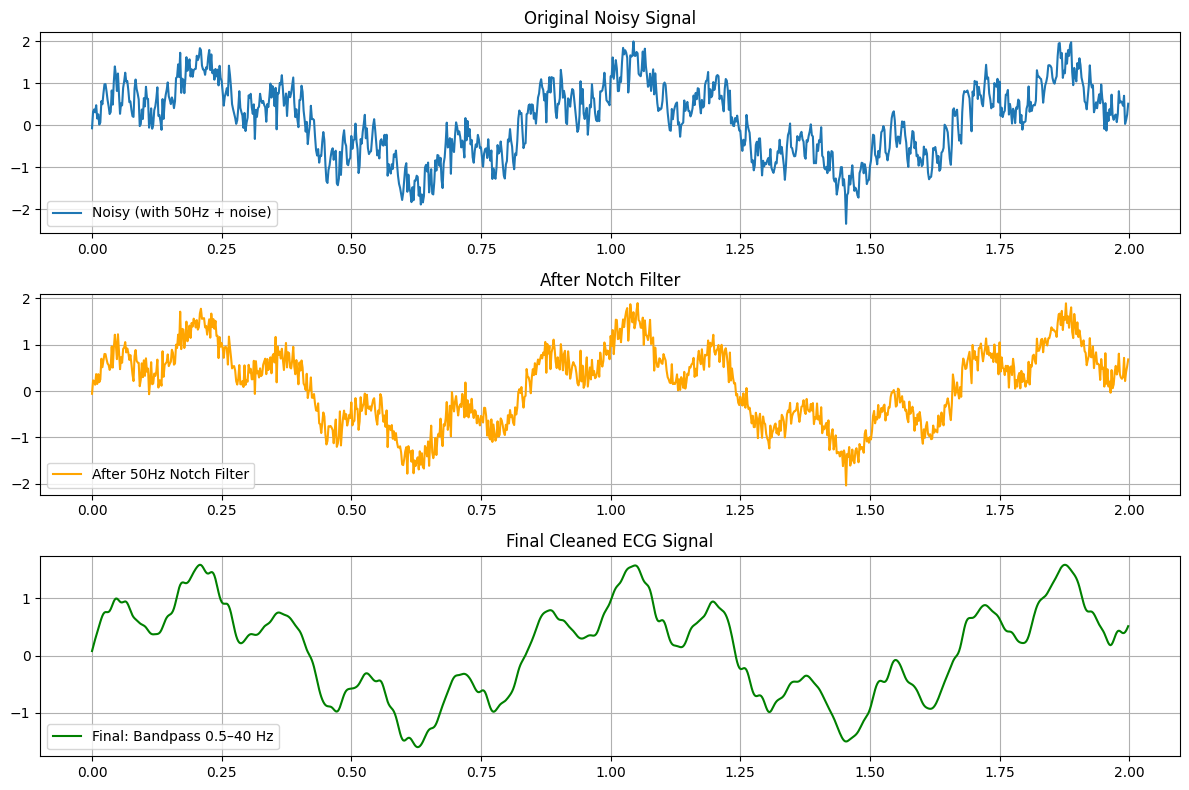


Final signal metadata:
{'patient_id': '001', 'domain': 'ecg', 'description': 'synthetic', 'filter': 'butterworth_bandpass'}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from signal_io.base import Signal
from dsp.filters import butterworth_filter, notch_filter

# -------------------------------
# 1. Create a synthetic ECG-like signal with noise
# -------------------------------
fs = 500  # Sampling rate in Hz
t = np.linspace(0, 10, 10 * fs, endpoint=False)  # 10 seconds

# Clean ECG-like signal (simplified heartbeat pattern)
clean_ecg = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 6 * t)

# Add power line interference (50 Hz in India)
noise_50hz = 0.3 * np.sin(2 * np.pi * 50 * t)

# Add some random noise
noise_random = 0.2 * np.random.randn(len(t))

# Final noisy signal
noisy_ecg = clean_ecg + noise_50hz + noise_random

# Wrap into Signal object
ecg_signal = Signal(
    data=noisy_ecg,
    sampling_rate=fs,
    signal_type="ecg",
    metadata={"patient_id": "001", "domain": "ecg", "description": "synthetic"}
)

print("Original signal:")
ecg_signal.summary()

# -------------------------------
# 2. Apply filters
# -------------------------------

# Remove 50 Hz power line noise
ecg_notch = notch_filter(ecg_signal, notch_freq=50.0, quality_factor=30)

# Apply bandpass filter typical for ECG: 0.5–40 Hz
ecg_filtered = butterworth_filter(
    ecg_notch,
    filter_type="bandpass",
    low_freq=0.5,
    high_freq=40,
    order=4
)

# -------------------------------
# 3. Visualize results
# -------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t[:1000], ecg_signal.data[:1000], label="Noisy (with 50Hz + noise)")
plt.title("Original Noisy Signal")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t[:1000], ecg_notch.data[:1000], label="After 50Hz Notch Filter", color="orange")
plt.title("After Notch Filter")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t[:1000], ecg_filtered.data[:1000], label="Final: Bandpass 0.5–40 Hz", color="green")
plt.title("Final Cleaned ECG Signal")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print metadata to see filter history
print("\nFinal signal metadata:")
print(ecg_filtered.metadata)

Original signal:
Signal Summary
----------------------------------------
Sampling Rate : 500 Hz
Signal Type   : generic
Channels      : 1
Samples       : 4,000
Duration      : 8.000 seconds
Metadata      : {'domain': 'ecg', 'subject': 'simulated', 'condition': 'rest'}


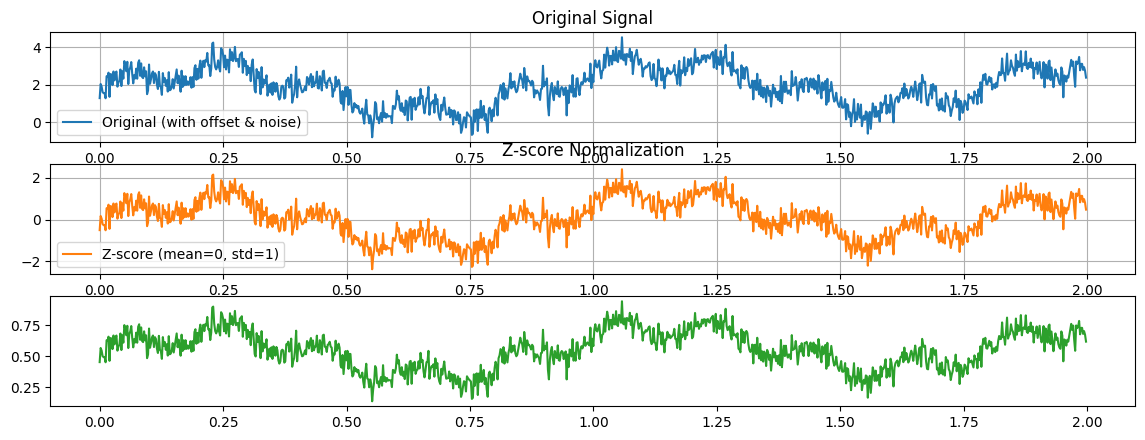

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from signal_io.base import Signal
from dsp.normalization import (
    zscore_normalize,
    minmax_normalize,
    peak_normalize,
    unit_energy_normalize,
    mean_normalize
)

# 1. Create a synthetic noisy signal (e.g. ECG-like + baseline wander + noise)
fs = 500  # Hz
t = np.linspace(0, 8, 8 * fs, endpoint=False)

# Simulated ECG pattern + slow baseline + high-frequency noise
ecg_pattern = 1.2 * np.sin(2 * np.pi * 1.1 * t) + 0.6 * np.sin(2 * np.pi * 5 * t)
baseline = 0.8 * np.sin(2 * np.pi * 0.08 * t)          # slow wander
noise = 0.4 * np.random.randn(len(t))

raw_signal = ecg_pattern + baseline + noise + 1.5      # positive offset

# Wrap into Signal object
sig = Signal(
    data=raw_signal,
    sampling_rate=fs,
    metadata={"domain": "ecg", "subject": "simulated", "condition": "rest"}
)

print("Original signal:")
sig.summary()

# 2. Apply different normalizations
sig_zscore = zscore_normalize(sig)
sig_minmax = minmax_normalize(sig, min_val=0, max_val=1)
sig_peak = peak_normalize(sig)
sig_unit_energy = unit_energy_normalize(sig)
sig_mean_norm = mean_normalize(sig)

# 3. Visualize comparison (first 2 seconds)
t_short = t[:1000]
plt.figure(figsize=(14, 10))

plt.subplot(6, 1, 1)
plt.plot(t_short, sig.data[:1000], label='Original (with offset & noise)')
plt.title('Original Signal')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(t_short, sig_zscore.data[:1000], 'C1', label='Z-score (mean=0, std=1)')
plt.title('Z-score Normalization')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(t_short, sig_minmax.data[:1000], 'C2', label='Min-Max [0,1]')


Signal Summary
----------------------------------------
Sampling Rate : 1000 Hz
Signal Type   : generic
Channels      : 1
Samples       : 10,000
Duration      : 10.000 seconds
Metadata      : {'domain': 'synthetic', 'description': 'mixed frequencies + burst + noise', 'components': '5Hz + 50Hz + 120Hz + 250Hz burst'}


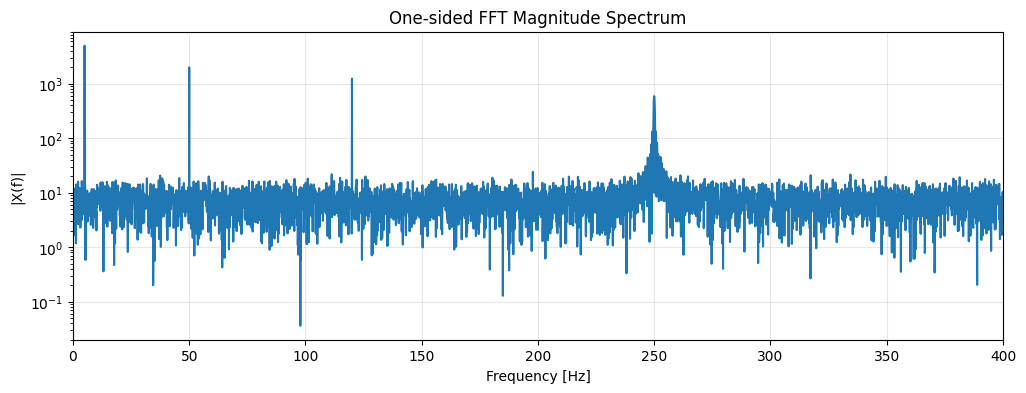

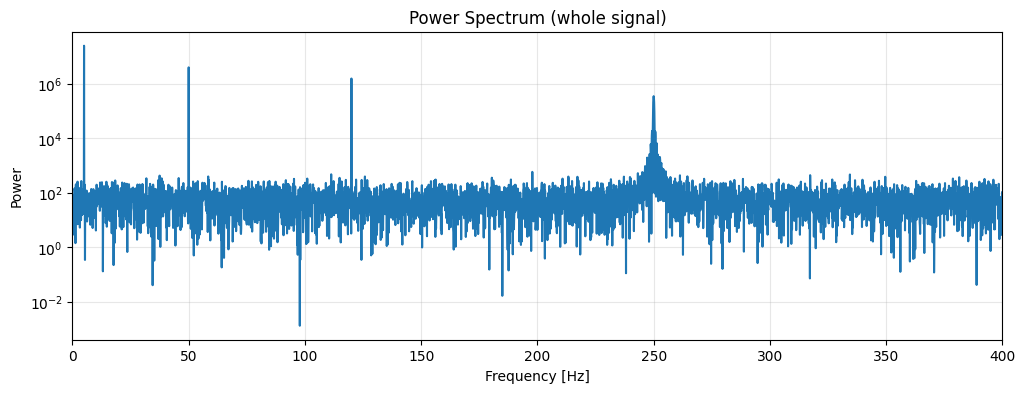

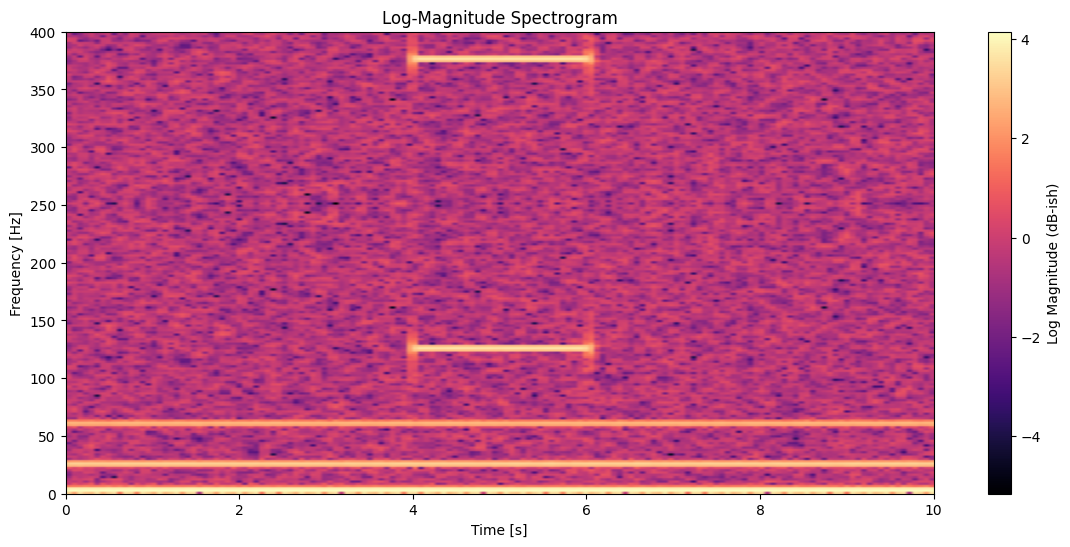

ValueError: operands could not be broadcast together with shapes (1,120) (128,) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from signal_io.base import Signal

from dsp.spectral import (
    fft,
    stft,
    power_spectrum,
    spectrogram,
    frequency_bins,
    band_energy
)

# ────────────────────────────────────────────────────────────────
# 1. Create a synthetic signal: 10 seconds of mixed frequencies
# ────────────────────────────────────────────────────────────────
fs = 1000          # Sampling rate 1 kHz
duration = 10
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Components:
# - 5 Hz slow oscillation (like breathing/theta rhythm)
# - 50 Hz power line interference
# - 120 Hz harmonic
# - 200–300 Hz burst (like muscle artifact or gamma)
signal = (
    1.0 * np.sin(2 * np.pi * 5 * t) +
    0.4 * np.sin(2 * np.pi * 50 * t) +
    0.25 * np.sin(2 * np.pi * 120 * t) +
    0.6 * (np.sin(2 * np.pi * 250 * t) * (t > 4) * (t < 6))  # burst between 4–6s
)

# Add a tiny bit of noise
signal += 0.08 * np.random.randn(len(t))

# Wrap into Signal object (single channel)
sig = Signal(
    data=signal,
    sampling_rate=fs,
    metadata={
        "domain": "synthetic",
        "description": "mixed frequencies + burst + noise",
        "components": "5Hz + 50Hz + 120Hz + 250Hz burst"
    }
)

sig.summary()

# ────────────────────────────────────────────────────────────────
# 2. Basic FFT (whole signal)
# ────────────────────────────────────────────────────────────────
fft_vals = fft(sig)
freqs = np.fft.fftfreq(len(signal), d=1/fs)

# Only positive frequencies for plotting
pos_mask = freqs >= 0
plt.figure(figsize=(12, 4))
plt.semilogy(freqs[pos_mask], np.abs(fft_vals)[pos_mask])
plt.title("One-sided FFT Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|X(f)|")
plt.grid(True, alpha=0.3)
plt.xlim(0, 400)
plt.show()

# ────────────────────────────────────────────────────────────────
# 3. Power Spectrum
# ────────────────────────────────────────────────────────────────
power = power_spectrum(sig)
plt.figure(figsize=(12, 4))
plt.semilogy(freqs[pos_mask], power[pos_mask])
plt.title("Power Spectrum (whole signal)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.grid(True, alpha=0.3)
plt.xlim(0, 400)
plt.show()

# ────────────────────────────────────────────────────────────────
# 4. Spectrogram (time-frequency view)
# ────────────────────────────────────────────────────────────────
# After computing the spectrogram
spec = spectrogram(sig, window_size=256, hop_size=64, log_scale=True)

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    spec,                    # now real-valued (float)
    origin='lower',
    aspect='auto',
    extent=[0, duration, 0, fs/2],
    cmap='magma'
)
plt.colorbar(label='Log Magnitude (dB-ish)')
plt.title("Log-Magnitude Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.ylim(0, 400)             # zoom to interesting range
plt.show()

# ────────────────────────────────────────────────────────────────
# 5. Band Energy over time (e.g., gamma band 30–100 Hz)
# ────────────────────────────────────────────────────────────────
gamma_energy = band_energy(sig, band=(30, 100), window_size=256, hop_size=64)

time_axis = np.arange(len(gamma_energy)) * (64 / fs)  # approximate time

plt.figure(figsize=(12, 4))
plt.plot(time_axis, gamma_energy)
plt.title("Energy in 30–100 Hz band over time")
plt.xlabel("Time [s]")
plt.ylabel("Band Energy")
plt.grid(True, alpha=0.3)
plt.show()

print("→ Notice the clear energy increase between 4–6 seconds (the 250 Hz burst)")